In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim 
import torchvision.datasets as dataset
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

####Downloading the data and normalize

In [43]:
train_set = dataset.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081))                                 
    ])
)

test_set = dataset.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081))                                 
    ])
)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [45]:
#batchsize for training and testing
batch_size = 1000

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True)


In [12]:
data = enumerate(train_loader)
batch_idx, (images_data, images_labels) = next(data)

In [13]:
images_data.shape

torch.Size([1000, 1, 28, 28])

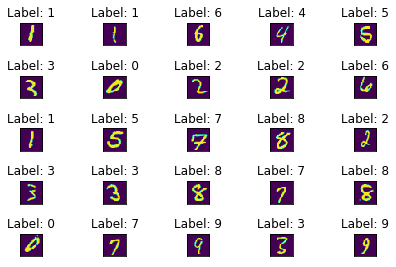

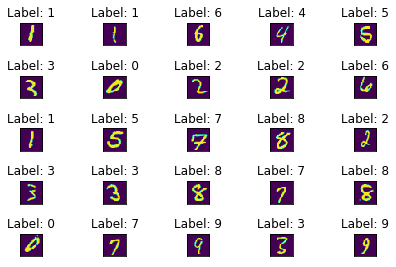

In [17]:
fig = plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(images_data[i][0], interpolation='none')
  plt.title("Label: {}".format(images_labels[i]))
  plt.xticks([])
  plt.yticks([])
fig 

To calculate output size, we will use the formula (W - K + 2P/S) + 1
where W : width = 28, K : filter size(kernel_size) = 5, S : number of strides = 1, P : padding = 2
image dimensions are 28 * 28 * 1

The output from the 1st layer is 14 * 14 * 32

The output from the 2nd layer is 7 * 7 * 64


#### Defining the Neural Network structure

In [29]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        #Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride = 1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride = 1, padding=2)
        #Max Pooling Layer
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #Fully Connected Layer
        self.fc1 = nn.Linear(7*7*64, 1000)
        self.fc2 = nn.Linear(1000,10)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        # flatten the data dimension from 7*7*64 into 3136*1 (i.e., reshaping the tensor)
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = self.fc2(x)
# No need to use softmax function as it is already included in CrossEntropyLoss()
        return x

In [38]:
epochs = 100
log_interval = 10 
learning_rate = 0.001
train_counter = []
train_loss = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [31]:
#loss functions and optimization algo
model = ConvNet()
model.to(device) #transfer to GPU if available
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_func = nn.CrossEntropyLoss()

####Training the model

In [37]:
gradient_norm = []
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 55)
# Train the model
    model.train() 
    for batch_idx, data_set in enumerate(train_loader):
        
        data , target = data_set
        data = data.to(device)
        target = target.to(device)
        # Forward propagation
        optimizer.zero_grad()  # set gradients to zero
        output = model(data)   
        output.to(device)
        loss = loss_func(output,target) # compute loss

        # Back propagation and perform adam optimization
        loss.backward() # calculate gradients
        optimizer.step()  # update weights

        if batch_idx % log_interval == 0:
         print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
           epoch, batch_idx * len(data), len(train_loader.dataset),
           100. * batch_idx / len(train_loader), loss.item()))
         
        train_loss.append(loss.item())
        train_counter.append((batch_idx*100) + ((epoch-1)*len(train_loader.dataset)))
    
    total_tr_loss = sum(train_loss)/(batch_idx + 1)
    print(f"Total train loss : {total_tr_loss}")
    # Calculating gradient norm
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad and "bias" not in name:
            # Uncomment any of the below line if you want to see the gradient values
            #print (name, param.grad.data)
            #print(f'{name}.grad', param.grad, epoch)
            gradients.append(torch.flatten(param.grad.data))
    print(f'Grad_norm : {torch.norm(torch.cat([gradients[0],gradients[1],gradients[2],gradients[3]],dim=0))}')
    gradient_norm.append(torch.norm(torch.cat([gradients[0],gradients[1],gradients[2],gradients[3]],dim=0)).item())

Epoch 0/99
-------------------------------------------------------
Train Epoch: 0 [0/60000 (0%)]	 Loss: 0.010447
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 0.004814
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 0.002930
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 0.010728
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 0.002728
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 0.014765
Total train loss : 0.007159978830410789
Grad_norm : 0.2707873582839966
Epoch 1/99
-------------------------------------------------------
Train Epoch: 1 [0/60000 (0%)]	 Loss: 0.004237
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 0.002817
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 0.004179
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 0.006608
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 0.003489
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 0.012051
Total train loss : 0.01392101778377158
Grad_norm : 0.1276119500398636
Epoch 2/99
-------------------------------------------------------
Train Epoch: 2 [0/60000 (0%)]	 Loss: 0.004340
Train Epoc

In [39]:
print(len(gradient_norm))

100


In [41]:
ep = [e for e in range(epochs)]
#ep

#### Evaluating and testing the model

In [46]:
correct = 0
total = 0
pred = []
# Test the model
model.eval()
test_loss = 0
for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  test_loss += loss_func(output,target)
  _, predicted = torch.max(output.data,1)
  pred.append(output)
  total += target.size(0)
  correct += (predicted == target).sum().item()

test_loss = test_loss/len(test_loader.dataset)
print('Average loss for the test set is {} \nThe test accuracy of the 2-layered cnn model on the {} test images: {} %'.format(test_loss, len(test_set),(correct / (total)) * 100))

Average loss for the test set is 5.196604615775868e-05 
The test accuracy of the 2-layered cnn model on the 10000 test images: 99.28 %


####Plot of gradient norm vs epoch

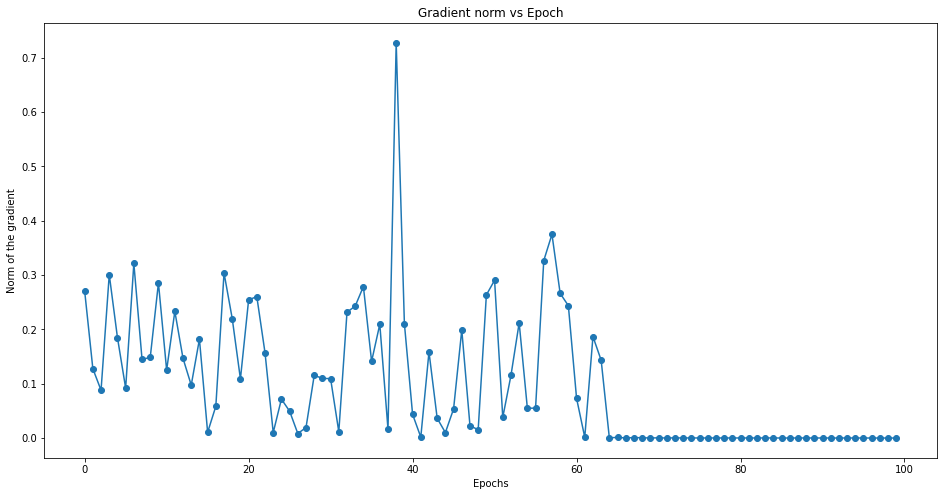

In [61]:
#line graph
fig = plt.figure()
fig.set_size_inches(16, 8)
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
plt.scatter(ep,gradient_norm)
plt.plot(ep,gradient_norm)
plt.title("Gradient norm vs Epoch")
plt.savefig('line plot of gradient norm vs epoch (with 100 epoch).pdf',dpi = 300)

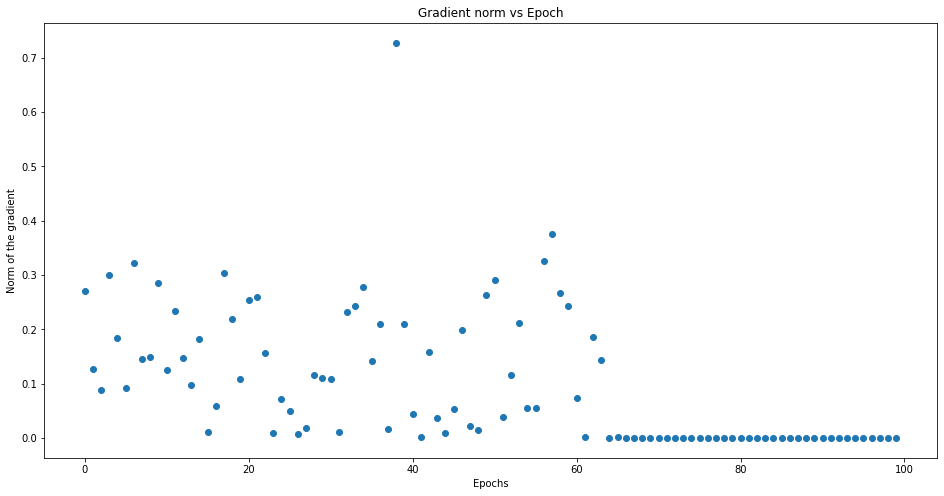

In [57]:
#scatter plot
fig = plt.figure()
fig.set_size_inches(16, 8)
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
plt.scatter(ep,gradient_norm)
plt.title("Gradient norm vs Epoch")
plt.savefig('scatter plot of gradient norm vs epoch (with 100 epochs).pdf',dpi = 300)